In [63]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split
import rebound
import itertools
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios
from celmech.andoyer import get_num_fixed_points
from collections import OrderedDict
plt.style.use('paper')

In [48]:
modelfile = 'ressummaryfeaturesxgb_resonantv3.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
respath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/'
sapath = 'simulation_archives/runs/sa'
trainingdatafolder = datapath+dset+featurefolder

model, features, featurefolder = dill.load(open(repopath+"models/"+modelfile, 'rb'))

In [15]:
labels = pd.read_csv(trainingdatafolder+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [30]:
Nrows = int(0.8*labels.shape[0])
testlabels = labels.iloc[Nrows:]
testlabels.shape

(2000, 4)

In [22]:
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [27]:
testlabels.head()

,runstring,instability_time,shadow_instability_time,Stable
7999,0008000.bin,1.000000e+09,1.000000e+09,True
8000,0008001.bin,1.659450e+04,1.785363e+03,False
8001,0008002.bin,8.519776e+05,6.193542e+05,False
8002,0008003.bin,2.874284e+06,2.616865e+07,False
8003,0008004.bin,1.000000e+09,1.000000e+09,True


In [28]:
testY.head()

7999     True
8000    False
8001    False
8002    False
8003     True
Name: Stable, dtype: bool

In [37]:
preds = model.predict_proba(testX)[:,1]
testlabels['stab_pred'] = preds

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

from scipy.optimize import brenth
def F(e,alpha,gamma):
    """Equation 35 of Laskar & Petit (2017)"""
    denom = np.sqrt(alpha*(1-e*e)+gamma*gamma*e*e)
    return alpha*e -1 + alpha + gamma*e / denom

### start AMD functions

def critical_relative_AMD(alpha,gamma):
    """Equation 29"""
    e0 = np.min((1,1/alpha-1))
    ec = brenth(F,0,e0,args=(alpha,gamma))
    e1c = np.sin(np.arctan(gamma*ec / np.sqrt(alpha*(1-ec*ec))))
    curlyC = gamma*np.sqrt(alpha) * (1-np.sqrt(1-ec*ec)) + (1 - np.sqrt(1-e1c*e1c))
    return curlyC

def compute_AMD(sim):
    pstar = sim.particles[0]
    Ltot = pstar.m * np.cross(pstar.xyz,pstar.vxyz)
    ps = sim.particles[1:]
    Lmbda=np.zeros(len(ps))
    G = np.zeros(len(ps))
    Lhat = np.zeros((len(ps),3))
    for k,p in enumerate(sim.particles[1:]):
        orb = p.calculate_orbit(primary=pstar)
        Lmbda[k] = p.m * np.sqrt(p.a)
        G[k] = Lmbda[k] * np.sqrt(1-p.e*p.e)
        hvec = np.cross(p.xyz,p.vxyz)
        Lhat[k] = hvec / np.linalg.norm(hvec)
        Ltot = Ltot + p.m * hvec
    cosi = np.array([Lh.dot(Ltot) for Lh in Lhat]) / np.linalg.norm(Ltot)
    return np.sum(Lmbda) - np.sum(G * cosi)

def AMD_stable_Q(sim):
    AMD = compute_AMD(sim)
    pstar = sim.particles[0]
    ps = sim.particles[1:]
    for i in range(len(ps)-1):
        pIn = ps[i]
        pOut = ps[i+1]
        orbIn = pIn.calculate_orbit(pstar)
        orbOut = pOut.calculate_orbit(pstar)
        alpha = orbIn.a / orbOut.a
        gamma = pIn.m / pOut.m
        LmbdaOut = pOut.m * np.sqrt(orbOut.a)
        Ccrit = critical_relative_AMD(alpha,gamma)
        C = AMD / LmbdaOut
        if C>Ccrit:
            return False
    return True

def AMD_stability_coefficient(sim, i1, i2):
    AMD = compute_AMD(sim)
    ps = sim.particles
    pstar = ps[0]
    
    pIn = ps[i1]
    pOut = ps[i2]
    orbIn = pIn.calculate_orbit(pstar)
    orbOut = pOut.calculate_orbit(pstar)
    alpha = orbIn.a / orbOut.a
    gamma = pIn.m / pOut.m
    LmbdaOut = pOut.m * np.sqrt(orbOut.a)
    Ccrit = critical_relative_AMD(alpha,gamma)
    C = AMD / LmbdaOut
    return C / Ccrit

In [88]:
def findres2(sim, i1, i2):
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[i1].M
    m2 = ps[i2].m/ps[i2].M

    Pratio = n2/n1
    if np.isnan(Pratio): # probably due to close encounter where averaging step doesn't converge 
        return np.nan, np.nan, np.nan

    delta = 0.03
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)
    
    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        
    j, k, i1, i2, maxstrength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*(Z/Zcross)**((b-a)/2.)/((b*n2 - a*n1)/n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            maxstrength = s
    
    if maxstrength > -1:
        return j, k, maxstrength
    else:
        return np.nan, np.nan, np.nan
    
def info(row):
    runstring = row['runstring']#'{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    simf = sa[-1]

    N = simf.N
    ps = simf.particles
    mindRH = 100.
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        d = np.sqrt((ps[i1].x-ps[i2].x)**2 + (ps[i1].y-ps[i2].y)**2 + (ps[i1].z-ps[i2].z)**2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        if d/RH < mindRH:
            dRHi = [i1, i2] # two indices that collided
            mindRH = d/RH
    print('Particles {0} collided at t = {1:.2e}'.format(dRHi, sa[-1].t))

    sim = sa[0]
    ps = sim.particles
    for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1, i2 = int(i1), int(i2)
        j, k, strength = findres2(sim, i1, i2) # max strength between i1 and i2
        Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        beta = (ps[i2].a-ps[i1].a)/RH
        emZc = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)/Zcross
        if strength > -1:
            print('Pair {0}{1}: Zcross = {2:.3f}, Z/Zcross = {3:.3f}, delta a/RH = {4:.2f}, Strongest Resonance (strength) = {5}:{6} ({7:.2f})'.format(i1, i2, Zcross, emZc, beta, j, j-k, strength))
        else:
            print('Pair {0}{1}: Zcross = {2:.3f}, Z/Zcross = {3:.3f}, delta a/RH = {4:.2f}, Strongest Resonance = None'.format(i1, i2, Zcross, emZc, beta))
    return  rebound.OrbitPlot(sa[0])

In [89]:
def fillnan(features, pairs):
    features['tlyap'] = np.nan
    features['megno'] = np.nan
    
    for i, [label, i1, i2] in enumerate(pairs):
        features['EMmed'+label] = np.nan
        features['EMmax'+label] = np.nan
        features['EMdrift'+label] = np.nan
        features['EMrollingstd'+label] = np.nan
        features['Zcommed'+label] = np.nan
        features['Zsepouter'+label] = np.nan
        features['ZfreeIC'+label] = np.nan
        features['ZfreeOC'+label] = np.nan
        features['Zfree'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstarstd'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstardrift'+label] = np.nan

def plot(row):
    runstring = row['runstring']#'{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    sim = sa[snapshot]

    Norbits = 1e4
    Nout = 1000
    ###############################
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.ri_whfast.safe_mode = 0
    ##############################
    features = OrderedDict()
    ps = sim.particles
    sim.init_megno()
    N = sim.N - sim.N_var
    a0 = [0] + [sim.particles[i].a for i in range(1, N)]
    Npairs = int((N-1)*(N-2)/2)
    maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1
    betas = np.zeros(Npairs)
    #print('pairindex, i1, i2, j, k, strength')
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1); i2 = int(i2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        betas[i] = (ps[i2].a-ps[i1].a)/RH
        
    features['betaouter'] = betas[1]
    if betas[0] < betas[2]:
        features['nearpair'] = 12 # for visualization and debugging
        features['betanear'] = betas[0]
        features['betafar'] = betas[2]
        pairs = [['near', 1,2], ['far', 2, 3], ['outer', 1, 3]]
    else:
        features['nearpair'] = 23
        features['betanear'] = betas[2]
        features['betafar'] = betas[0]
        pairs = [['near', 2, 3], ['far', 1, 2], ['outer', 1, 3]]
    
    Zsepinners, Zsepouters, separatrixdist = np.zeros(Npairs), np.zeros(Npairs), np.zeros(Npairs)
    Zcross = np.zeros(Npairs)
    for i, [label, i1, i2] in enumerate(pairs):
        features['numfixedpoints'+label] = np.nan
        features['j'+label], features['k'+label], features['strength'+label] = findres2(sim, i1, i2) # returns nans if no res found
        features["C_AMD"+label] = AMD_stability_coefficient(sim, i1, i2)
        Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        features['Zcross'+label] = Zcross[i]
        if np.isnan(features['strength'+label]) == False:
            pvars = Poincare.from_Simulation(sim)
            avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            features['numfixedpoints'+label] = get_num_fixed_points(features['k'+label], avars.Phiprime)
            Zsepinners[i] = avars.Zsep_inner
            Zsepouters[i] = avars.Zsep_outer
            separatrixdist[i] = min(Zsepouters[i]-avars.Zstar, avars.Zstar-Zsepinners[i])
            
    P0 = ps[1].P
    times = np.linspace(0, Norbits*P0, Nout)
    rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zsepinner, rebound_Zsepouter = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstarnonres, rebound_Zstarunstable = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    eminus = np.zeros((Npairs,Nout))
    
    features['unstablein1e4'] = False # Assume not and update if true
    for i,t in enumerate(times):
        for j, [label, i1, i2] in enumerate(pairs):
            #i1 = int(i1); i2 = int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            if np.isnan(features['strength'+label]) == False:
                pvars = Poincare.from_Simulation(sim)
                avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            
                rebound_Z[j, i] = avars.Z
                rebound_phi[j, i] = avars.phi
                rebound_Zcom[j, i] = avars.Zcom
                rebound_phiZcom[j, i] = avars.phiZcom
                rebound_Zstar[j, i] = avars.Zstar
                rebound_dKprime[j, i] = avars.dKprime
                rebound_Zsepinner[j, i] = avars.Zsep_inner
                rebound_Zsepouter[j, i] = avars.Zsep_outer
                rebound_Zstarnonres[j, i] = avars.Zstar_nonres
                rebound_Zstarunstable[j, i] = avars.Zstar_unstable
        try:
            sim.integrate(t*P0, exact_finish_time=0)
        except:
            features['unstablein1e4'] = True
            break
            
    fillnan(features, pairs)
    if features['unstablein1e4'] == True:
        return 
    
    # Features with or without resonances:
    tlyap = 1./np.abs(sim.calculate_lyapunov())/P0
    if tlyap > Norbits:
        tlyap = Norbits
    features['tlyap'] = tlyap
    features['megno'] = sim.calculate_megno()
    
    for i, [label, i1, i2] in enumerate(pairs):
        Zc = features['Zcross'+label]
        EM = eminus[i,:]/Zc
        features['EMmed'+label] = np.median(EM)
        features['EMmax'+label] = EM.max()
        try:
            p = np.poly1d(np.polyfit(times, EM, 3))
            m = p(times)
            EMdrift = np.abs((m[-1]-m[0])/m[0])
            features['EMdrift'+label] = EMdrift
        except:
            pass
        rollstd = pd.Series(EM).rolling(window=10).std()
        features['EMrollingstd'+label] = rollstd[10:].median()/features['EMmed'+label]
        
        if np.isnan(features['strength'+label]) == False:
            features['Zcommed'+label] = np.median(rebound_Zcom[i,:])
            features['Zsepouter'+label] = Zsepouters[i]/Zc
            
            # try this one generically for variation in constants, since all fixed points seem to follow Zstar closely?
            if np.median(rebound_Zstar[i,:]) > 0:
                features['Zstarstd'+label] = rebound_Zstar[i,:].std()/np.median(rebound_Zstar[i,:])
                
            if np.median(rebound_Z[i,:]) < Zsepinners[i]:
                features['ZfreeIC'+label] = rebound_Z[i,:].max()/Zsepinners[i]
            elif np.median(rebound_Z[i,:]) > Zsepouters[i]:
                features['ZfreeOC'+label] = rebound_Z[i,:].min()/Zsepouters[i]
            else:
                if np.median(rebound_Zstar[i,:]) > 0:
                    features['Zstarmed'+label] = np.median(rebound_Zstar[i,:])/Zc
                    try:
                        p = np.poly1d(np.polyfit(times, rebound_Zstar[i,:], 3))
                        m = p(times)
                        Zstardrift = np.abs((m[-1]-m[0])/m[0])
                        features['Zstardrift'+label] = Zstardrift
                    except:
                        pass
                    features['Zfree'+label] = (rebound_Z[i,:]-rebound_Zstar[i,:]).std()/separatrixdist[i]
    
    fig, axarr = plt.subplots(nrows=8, ncols=3, figsize=(24,24))
    colors = ['orange', 'blue', 'green']
    Zlim = 0
    for i in range(3):
        Zlim = max(Zlim, np.max(np.abs(rebound_Z[i,:]/Zcross[i])))

    Zlim *= 1.5

    ax = axarr[0,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Z[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Z/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[0,1]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_phi[i,:], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('phi')
    ax.legend()

    ax = axarr[0,2]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsinphi/Zcross')
    ax.set_ylabel('Zcosphi/Zcross')
    ax.set_xlim([-Zlim, Zlim])
    ax.set_ylim([-Zlim, Zlim])
    ax.legend()

    ax = axarr[1,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zstar[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zstar/Zcross')
    ax.legend()

    ax = axarr[1,1]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zcom[i,:], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zcom')
    ax.legend()

    ax = axarr[1,2]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_phiZcom[i,:], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('phiZcom')
    ax.legend()

    ax = axarr[2,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_dKprime[i,:], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('dKprime')
    ax.legend()

    ax = axarr[2,1]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zstarnonres[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zstarnonres/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[2,2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zstarunstable[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zstarunstable/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[3,0]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zsepinner[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsepinner/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[3,1]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zsepouter[i,:]/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsepouter/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()
    
    ax = axarr[3,2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', c=colors[i], label=pairs[i])
            ax.plot(times, (rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i], '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('(Zsepouter-Zstar)/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()
    
    ax = axarr[4, 0]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', c=colors[i], label=pairs[i])
            
    ax.set_ylabel('(Z-Zstar)/Zcross')
    ax.legend()
    
    ax = axarr[4, 1]
    for i in range(3):
        if rebound_Zsepinner[i,:].mean() > 0:
            ax.plot(times, (rebound_Zsepinner[i,:]-rebound_Z[i,:])/rebound_Zsepinner[i,:], '.', c=colors[i], label=pairs[i])
            
    ax.set_ylabel('(Z-Zstar)/Zcross')
    ax.legend()
    
    ax = axarr[5, 0]
            
    for i, [label, i1, i2] in enumerate(pairs):
        Zc = features['Zcross'+label]
        EM = eminus[i,:]/Zc
        ax.plot(times, EM, '.', label=label)
        try:
            p = np.poly1d(np.polyfit(times, EM, 3))
            m = p(times)
            ax.plot(times, m, '--')
            EMdrift = np.abs((m[-1]-m[0])/m[0])
        except:
            pass
    
    ax.set_ylabel('EM/Zc')
    ax.legend()
    
    ax = axarr[6, 0]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['ZfreeIC'+label]) == False:
                ax.plot(times, rebound_Z[i,:]/Zsepinners[i], '.', c=colors[i], label=label)
    
    ax.set_ylabel('ZfreeIC/Zsepinner')
    ax.legend()
    
    ax = axarr[6, 1]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['ZfreeOC'+label]) == False:
                ax.plot(times, rebound_Z[i,:]/Zsepouters[i], '.', c=colors[i], label=label)
    
    ax.set_ylabel('ZfreeOC/Zsepouter')
    ax.legend()
    
    ax = axarr[6, 2]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['Zfree'+label]) == False:
                ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/separatrixdist[i], '.', c=colors[i], label=label)
    
    ax.set_ylabel('Zfree/separatrixdist')
    ax.legend()
    
    ax = axarr[7,0]
    i=0
    if rebound_Z[i,:].mean() > 0:
        ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsinphi/Zcross')
    ax.set_ylabel('Zcosphi/Zcross')
    ax.set_xlim([-Zlim, Zlim])
    ax.set_ylim([-Zlim, Zlim])
    ax.legend()
    
    ax = axarr[7,1]
    i=1
    if rebound_Z[i,:].mean() > 0:
        ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsinphi/Zcross')
    ax.set_ylabel('Zcosphi/Zcross')
    ax.set_xlim([-Zlim, Zlim])
    ax.set_ylim([-Zlim, Zlim])
    ax.legend()
    
    ax = axarr[7,2]
    i=2
    if rebound_Z[i,:].mean() > 0:
        ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', c=colors[i], label=pairs[i])

    ax.set_ylabel('Zsinphi/Zcross')
    ax.set_ylabel('Zcosphi/Zcross')
    ax.set_xlim([-Zlim, Zlim])
    ax.set_ylim([-Zlim, Zlim])
    ax.legend()
    return fig, features

In [38]:
testlabels.head()

,runstring,instability_time,shadow_instability_time,Stable,stab_pred
7999,0008000.bin,1.000000e+09,1.000000e+09,True,0.975000
8000,0008001.bin,1.659450e+04,1.785363e+03,False,0.000076
8001,0008002.bin,8.519776e+05,6.193542e+05,False,0.004088
8002,0008003.bin,2.874284e+06,2.616865e+07,False,0.263322
8003,0008004.bin,1.000000e+09,1.000000e+09,True,0.996853


# False Positives (predicted stable but actually unstable)

In [58]:
thresh = 0.43
fp = testlabels[(testlabels['stab_pred'] > thresh) & (testlabels['instability_time'] < 9.98e8)]

Text(0.5, 0, 'Actual Log Instability Timescale')

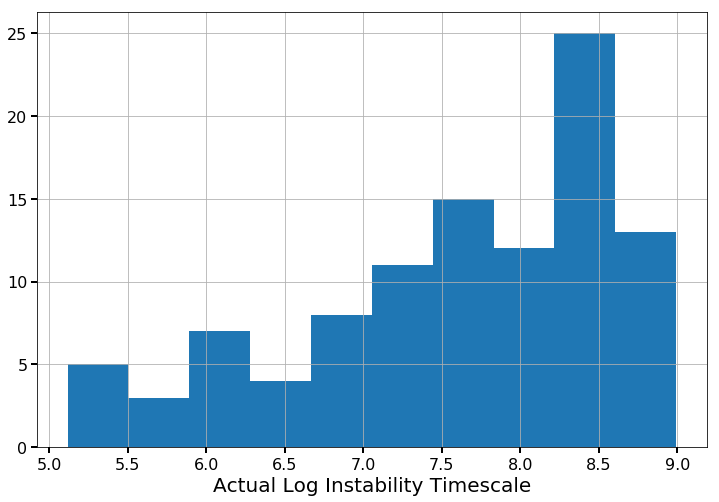

In [68]:
ax = np.log10(fp['instability_time']).hist(figsize=(12,8))
ax.set_xlabel('Actual Log Instability Timescale')

Text(0, 0.5, 'Actual Log Instability Timescale')

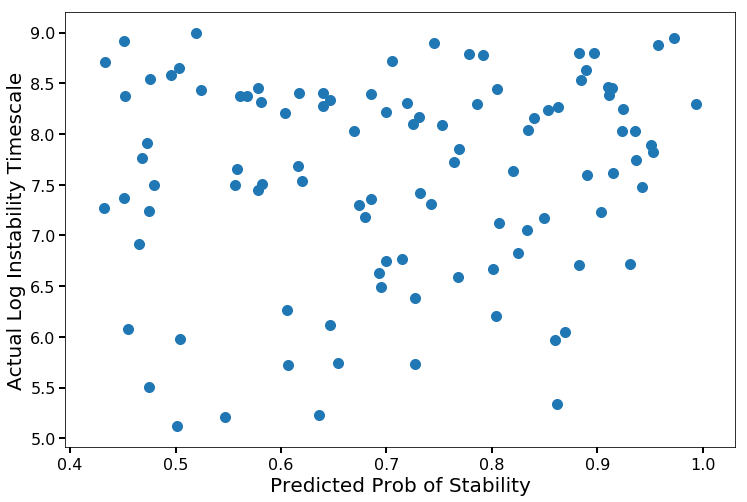

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(fp['stab_pred'], np.log10(fp['instability_time']))
ax.set_xlabel('Predicted Prob of Stability')
ax.set_ylabel('Actual Log Instability Timescale')

# Thought it was stable but very unstable

In [44]:
testlabels[(testlabels['stab_pred'] > 0.9) & (testlabels['instability_time'] < 1.e7)]

,runstring,instability_time,shadow_instability_time,Stable,stab_pred
8064,0008065.bin,5.189770e+06,1.540456e+07,False,0.931015


Particles [1, 2] collided at t = 5.19e+06
Pair 12: Zcross = 0.383, Z/Zcross = 0.280, delta a/RH = 13.23, Strongest Resonance (strength) = 5:3 (0.02)
Pair 13: Zcross = 0.812, Z/Zcross = 0.062, delta a/RH = 35.79, Strongest Resonance = None
Pair 23: Zcross = 0.310, Z/Zcross = 0.222, delta a/RH = 9.67, Strongest Resonance (strength) = 3:2 (8.83)


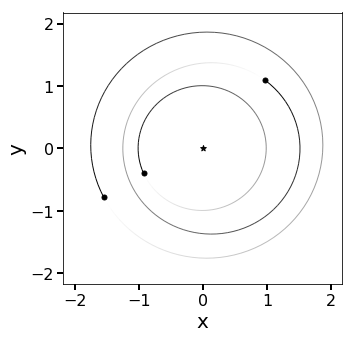

In [70]:
ID = 8065
fig = info(ID)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


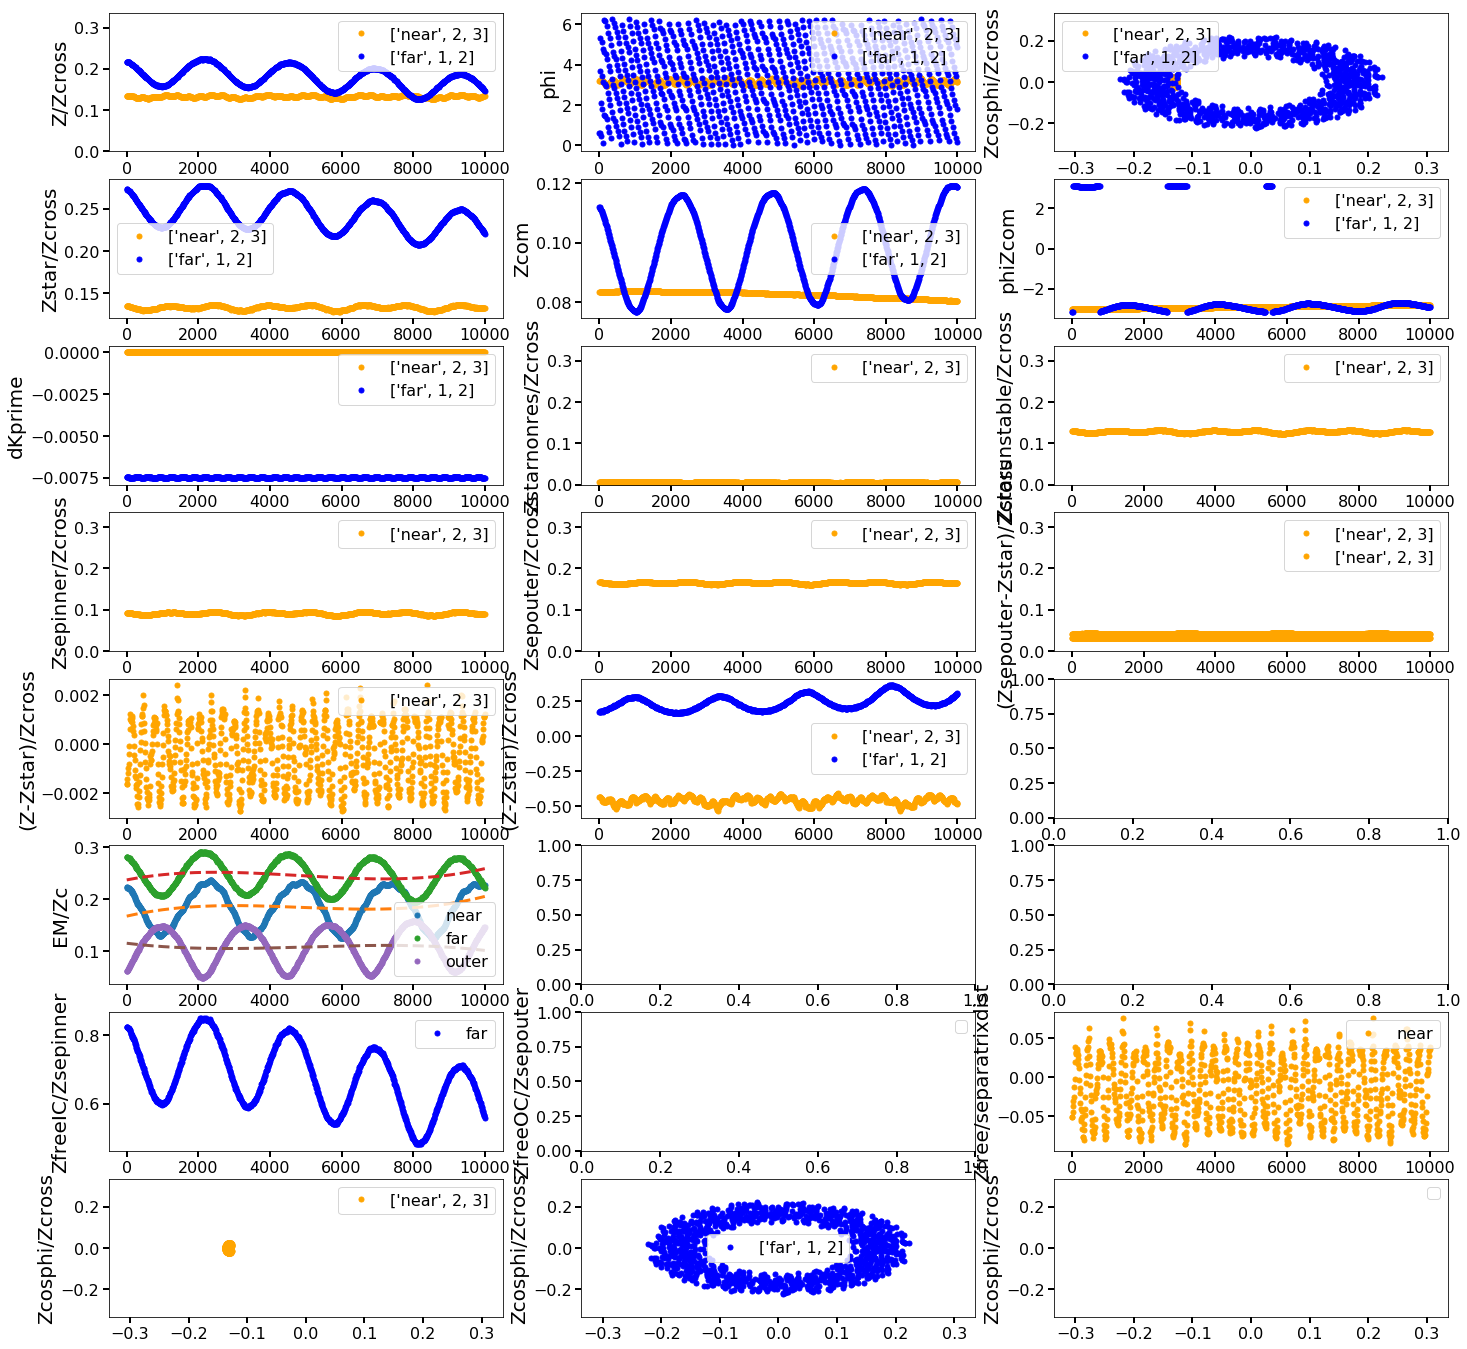

In [83]:
fig, features = plot(ID)

In [86]:
features

OrderedDict([('betaouter', 12.748580599409955),
             ('nearpair', 23),
             ('betanear', 7.155678371876131),
             ('betafar', 7.857495811077149),
             ('numfixedpointsnear', 3),
             ('jnear', 6),
             ('knear', 1),
             ('strengthnear', 10.61023034220886),
             ('C_AMDnear', 2.984748665430162),
             ('Zcrossnear', 0.12926881444992766),
             ('numfixedpointsfar', 3),
             ('jfar', 6),
             ('kfar', 1),
             ('strengthfar', 0.23537929032021332),
             ('C_AMDfar', 3.748322976254413),
             ('Zcrossfar', 0.13027644816363979),
             ('numfixedpointsouter', 3),
             ('jouter', 3),
             ('kouter', 1),
             ('strengthouter', 0.006964044996686422),
             ('C_AMDouter', 0.04240423858365344),
             ('Zcrossouter', 0.27638594461842864),
             ('unstablein1e4', False),
             ('tlyap', 1073.113302576862),
             ('meg

Particles [1, 2] collided at t = 4.55e+04
Pair 12: Zcross = 0.130, Z/Zcross = 0.547, delta a/RH = 7.86, Strongest Resonance (strength) = 6:5 (0.24)
Pair 13: Zcross = 0.276, Z/Zcross = 0.031, delta a/RH = 12.75, Strongest Resonance (strength) = 3:2 (0.01)
Pair 23: Zcross = 0.129, Z/Zcross = 0.523, delta a/RH = 7.16, Strongest Resonance (strength) = 6:5 (10.61)


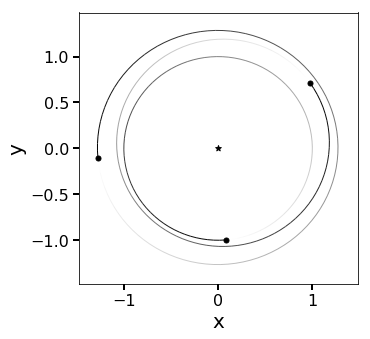

In [84]:
ID = 46
fig = info(ID)

No handles with labels found to put in legend.


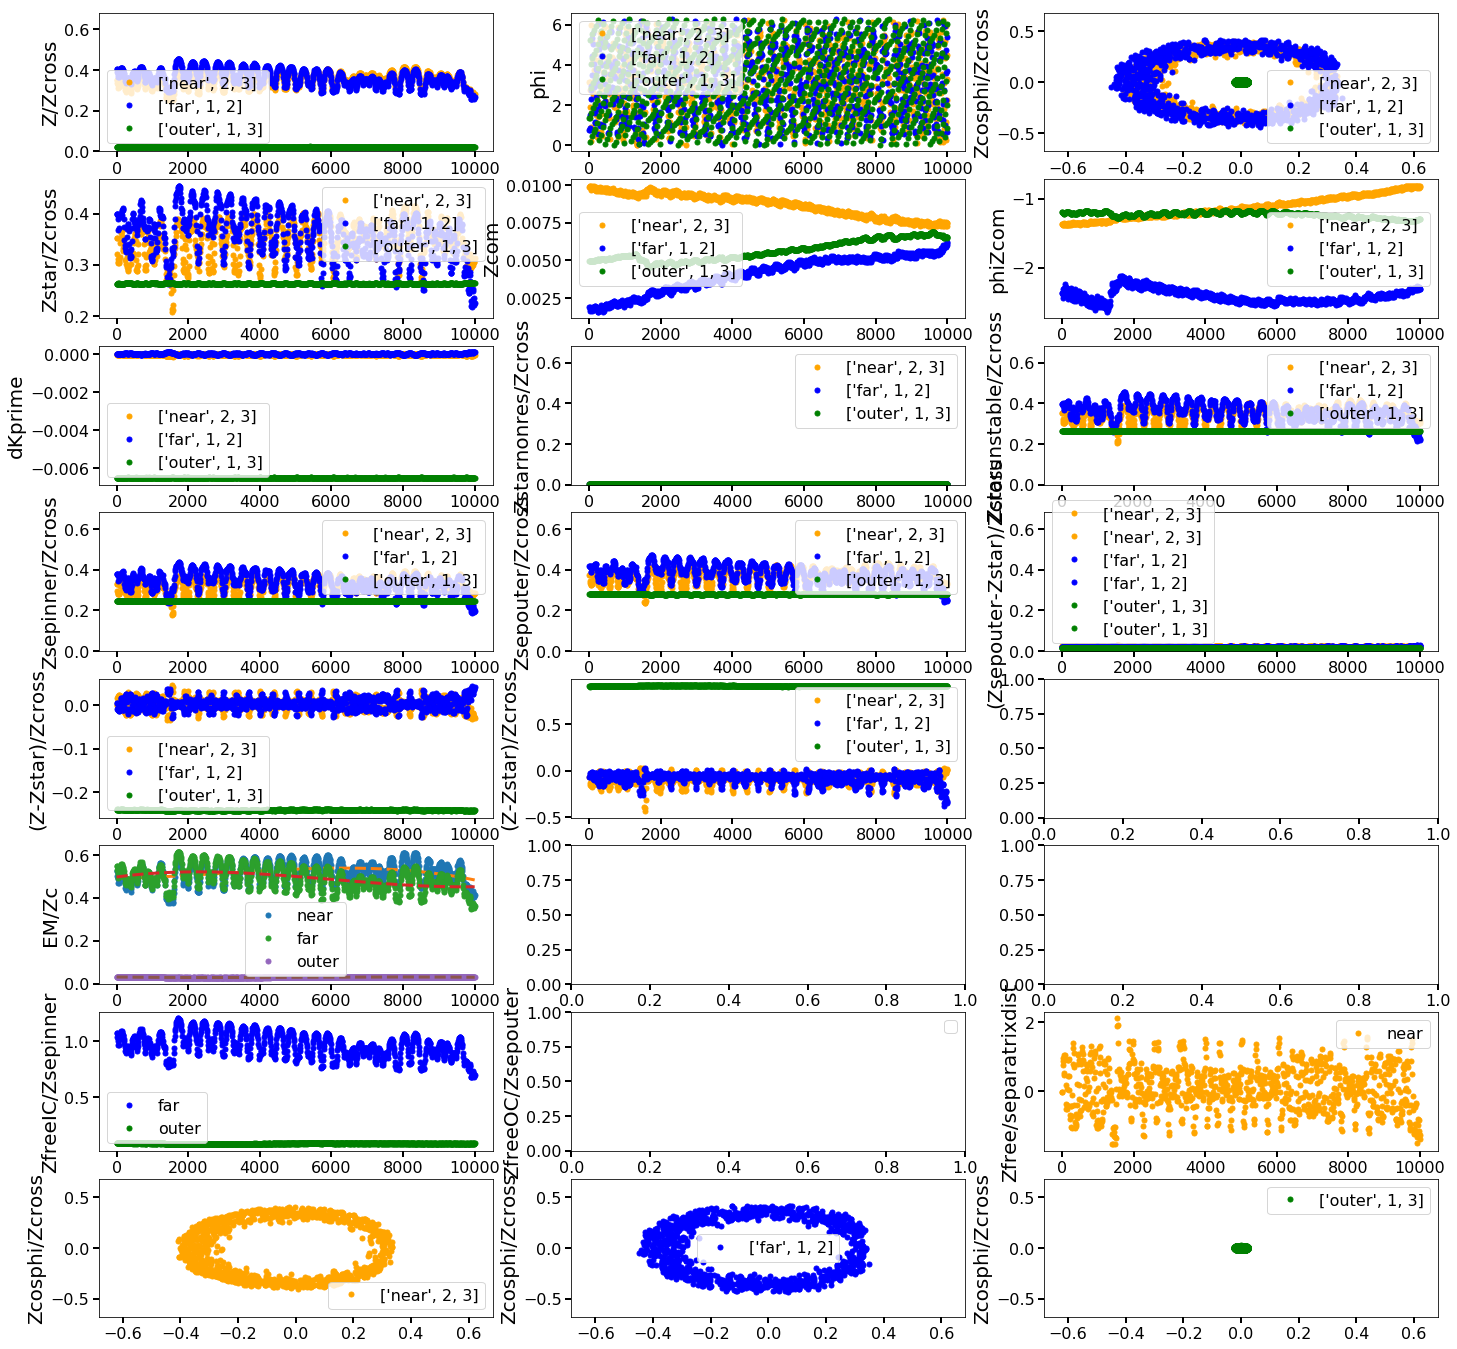

In [85]:
fig, features = plot(ID)

Particles [2, 3] collided at t = 1.55e+06
Pair 12: Zcross = 0.504, Z/Zcross = 0.083, delta a/RH = 19.83, Strongest Resonance = None
Pair 13: Zcross = 0.595, Z/Zcross = 0.058, delta a/RH = 36.75, Strongest Resonance (strength) = 2:1 (0.08)
Pair 23: Zcross = 0.060, Z/Zcross = 0.514, delta a/RH = 2.58, Strongest Resonance (strength) = 12:11 (0.67)


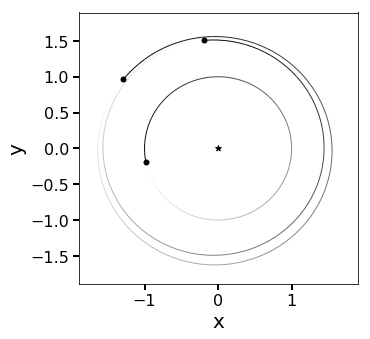

In [87]:
ID = 0
fig = info(ID)